In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')
import tokamakTK
from tokamakTK import get_ECT_regression, HUEOrder, get_pi_matrix, clean_numerical_data, MyCounter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
#import imageio
import imageio.v2 as imageio
from matplotlib.lines import Line2D
from PIL import Image
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
path = "../../data/"
fig_path = "../../../../LATEX/Latex Images/"

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

In [3]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

DB5 = tokamakTK.clean_categorical_data(DB5)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [4]:
# amount: images that the gif will contain
amount = 150

small_dataset = pd.read_csv(path+"decreased_dataset_random_sampling_500_decreasing_points.csv")
samples = [f"subset_{int(i)}" for i in np.linspace(1,len(small_dataset.columns)-1,amount)]
values = small_dataset[samples].describe().loc["min"]
indxs = [small_dataset[small_dataset[values.keys()[i]].isin([values.values[i]])].index[0] for i in range(amount)]

info = pd.DataFrame([np.linspace(1,len(small_dataset.columns)-1,amount),small_dataset.loc[indxs]["seed"].values]).T
info = info.rename(columns={0:"sampling", 1:"seed"})
info["sampling"] = info["sampling"].astype(int)
info["seed"] = info["seed"].astype(int)

In [5]:
DB5_decreas_pts = pd.read_csv(path+"decreasing_dataset_info.csv")
# Sampling on the decreasing points of the decreasing DS
#    If sampling is on "decreased": sampling on decreasing points in decreasing dataset (smaller alpha_R)
#    If sampling is on "weights": sampling on complete dataset only (highers alpha_R)
IDs = [
    DB5_decreas_pts.sample(n=info["sampling"][i], 
                           weights='decreased', 
                           random_state=info["seed"][i]) for i in range(amount)
]
    
# Adding mine with alpha_R of approx 0.63
IDs = IDs + [min_subset_ids_6357]

In [6]:
# Also serves as sanity check
# ----------------------------------------
DF = [DB5[DB5.id.isin(IDs[i].id.values) | DB5.id.isin(DB2.id.values)] for i in range(amount+1)]
ALPHAs = [get_ECT_regression(DF[i]).params["RGEO"] for i in range(len(DF))]

In [7]:
def get_3D_gif_DB5(i, indxs, saveFig = False, file_name=""):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = np.round(ALPHAs[i],2)

    x,y,z = "NUSTAR", "RHOSTAR", "Q95"
    DB5["colors"] = ["black"]*len(DB5)
    DB5.loc[(DB5[DB5.id.isin(indxs.id.values)].index), "colors"] = "red"

    # Plot the data points
    ax.scatter(DB5[x], DB5[y], DB5[z], c=DB5["colors"].values)
    ax.set_xlabel(x, fontsize=12, labelpad=10)
    ax.set_ylabel(y, fontsize=12, labelpad=10)
    ax.set_zlabel(z, fontsize=12, rotation=0)  
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='z', labelsize=12)

    ax.view_init(elev=25, azim=23) 
    
    ax.text(4.3, 0, 18, 'Decreasing', color='red', fontsize=15)
    ax.text(4.3, 0, 17, 'Unaffected', color='black', fontsize=15)
    ax.text(4.29, 0, 19.3, f"$\\alpha_R \\sim$ {alpha}", color='black', fontsize=17)
    
    if saveFig:
        plt.tight_layout()
        plt.savefig(path+file_name)
        plt.close()

In [8]:
def get_3D_plot_DB5_TOK(i, indxs, saveFig = False, file_name=""):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = np.round(ALPHAs[i],2)
    
    HUE_ORDER, PX_ORDER = tokamakTK.get_colors_per_category(DB5)
    category_colors = HUE_ORDER["TOK"]

    x,y,z = "NUSTAR", "RHOSTAR", "BETASTAR"
    DB5["colors"] = DB5["TOK"].map(category_colors)

    # Plot the data points
    scatter = ax.scatter(DB5[x], DB5[y], DB5[z], c=DB5["colors"].values)
    ax.set_xlabel(x, fontsize=12, labelpad=10)
    ax.set_ylabel(y, fontsize=12, labelpad=10)
    ax.set_zlabel(z, fontsize=12, rotation=0)  # Increase the labelpad to make it more visible
    
    # Add a legend
    legend_elements = []
    for category, color in category_colors.items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', 
                                          color='w', label=category, markerfacecolor=color, markersize=7))

    legend = ax.legend(handles=legend_elements, frameon=False,
                       loc='upper right', bbox_to_anchor=(1.2, 0.9), fontsize=8)


    ax.tick_params(axis='x', labelsize=12)  # x-axis ticks
    ax.tick_params(axis='y', labelsize=12)  # y-axis ticks
    ax.tick_params(axis='z', labelsize=12)  # z-axis ticks

    #fig.set_size_inches(16,13) 
    ax.view_init(elev=25, azim=23)

    
    if saveFig:
        plt.tight_layout()
        plt.savefig(path+file_name, format="pdf", dpi=800)
        #plt.close()

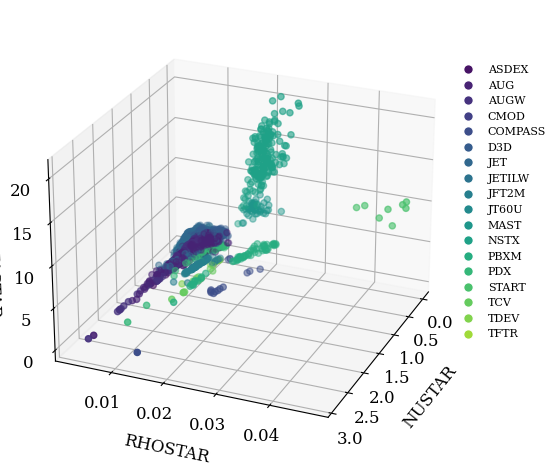

In [10]:
# EMEMBER TO DELETE THE test.png
get_3D_plot_DB5_TOK(15, IDs[15], True, "TOK/3D_BETASTAR_NUSTAR_RHOSTAR")
#get_3D_gif_DB5(15, IDs[15], True, "test")

In [ ]:
for i, indxs in enumerate(IDs):
    file_name = f"GIF_images/image_{i}.png"
    get_3D_gif_DB5(i, indxs, True, file_name)

In [ ]:
# HEAVY GIF (amount = 750)
x,y,z = "NUSTAR", "RHOSTAR", "BETASTAR"

image_folder = path+"GIF_images/"  # Path to the folder containing the images
output_file = f'change_in_{x}_{y}_{z}.gif'  # Output file name

# Get a list of PNG files in the folder
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
# Sort the image files by their numerical values in the filenames
image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

# Save the images in the folder as an animated GIF
imageio.mimsave(output_file, [imageio.imread(file) for file in image_files], fps=5)